# LASSO Regression

LASSO regression is the simplest version of regularized regression. 

Regularized regression means that we add a penalty term to the optimization problem to penalize the model's complexity. 

For the sake of intuition, imagine if we could penalize the number of non zero coeficients we add to the model. In that instance we would expect that the model would only consider the variables that really influence Y, and ignore the noise variables. LASSO regression does exactly that.

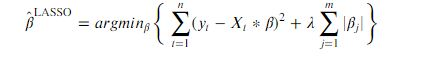

n is the number of data points, and m is the number of factors.

It is the same as the OLS regression, but with a second penalty term. As This directly penalizes the use of non zero coeficients and can set factor loadings to zero.

𝜆  is called a hyperparameter. Sikit-learn doesn't use  𝜆  it uses  𝛼  which can be related via the following equation.

𝜆/2∗𝑛=𝛼
Where 𝑛 is the number of data points. 
For now, let's arbitrarily pick 𝜆=.1

In [23]:
#import all the necessary packages
import numpy as np #for numerical array data
import pandas as pd #for tabular data
import matplotlib.pyplot as plt #for plotting purposes

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import importlib as imp
import warnings
warnings.filterwarnings('ignore')

In [24]:
#import cvxpy as cp
all_data = pd.read_csv("Data_Oct2018.csv")
all_data['Date'] = pd.to_datetime(all_data['Date'])

In [25]:
all_data.head()

,Date,World Equities,US Treasuries,Bond Risk Premium,Inflation Protection,Currency Protection,US Equities,Real Estate,Commodities,Corp Bonds
0,1985-01-01,0.028511,0.031500,0.006408,-0.016265,0.030292,0.081301,0.056605,0.021351,0.048963
1,1985-02-01,-0.009204,-0.044692,0.057381,0.006362,0.010258,0.030075,0.016448,-0.015217,-0.042029
2,1985-03-01,0.075134,0.028719,-0.024396,-0.002848,-0.020739,-0.007299,-0.006716,0.037171,0.032666
3,1985-04-01,-0.002459,0.023084,-0.004869,0.003089,0.008187,-0.012255,0.000906,-0.035116,0.037125
4,1985-05-01,0.040245,0.086780,-0.044417,0.004077,-0.002219,0.064516,0.027241,0.004351,0.104199


In [13]:
def create_options():
    '''create standard options dictionary to be used as input to regression functions'''
    options = dict()
    options['timeperiod'] = 'all'
    options['date'] = 'Date'
    options['returnModel'] = False
    options['printLoadings'] = True
    return options

In [14]:
def num_to_month(month):
    #num to month returns the name of the month, input is an integer
    if (month==1):
        return 'January'
    if (month==2):
        return 'Febuary'
    if (month==3):
        return 'March'
    if (month==4):
        return 'April'
    if (month==5):
        return 'May'
    if (month==6):
        return 'June'
    if (month==7):
        return 'July'
    if (month==8):
        return 'August'
    if (month==9):
        return 'September'
    if (month==10):
        return 'October'
    if (month==11):
        return 'November'
    if (month==12):
        return 'December'

In [15]:
def print_timeperiod(data, dependentVar, options):
    '''print_timeperiod takes a a dependent varaible and a options dictionary, prints out the time period
    INPUTS:
        data: pandas df, df with the data
        dependentVar: string, name of dependent variable
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
    OUTPUTS:
        printed stuff
    '''
    print ('Dependent Variable is ' + dependentVar)
    if(options['timeperiod'] == 'all'):
        sortedValues = data.sort_values(options['date'])[options['date']].reset_index(drop=True)
        n = sortedValues.shape[0]
        beginDate = sortedValues[0]
        endDate = sortedValues[n-1]
        print ('Time period is between ' + num_to_month(beginDate.month) +  ' ' + str(beginDate.year) + ' to ' + num_to_month(endDate.month) +  ' ' + str(endDate.year) + ' inclusive   ')        
    else:
        print ('Time period is ' + options['timeperiod'])

In [16]:
def display_factor_loadings(intercept, coefs, factorNames, options):
    '''display_factor_loadings takes an intercept, coefs, factorNames and options dict, and prints the factor loadings in a readable way
    INPUTS:
        intercept: float, intercept value
        coefs: np array, coeficients from pandas df
        factorNames: list, names of the factors
        options: dict, should contain at least one key, nameOfReg
            nameOfReg: string, name for the regression
    Outputs:
        output is printed
    '''
    loadings = np.insert(coefs, 0, intercept)
    if('nameOfReg' not in options.keys()):
        name = 'No Name'
    else:
        name = options['nameOfReg']
    out = pd.DataFrame(loadings, columns=[name])
    out = out.transpose()
    fullNames = ['Intercept'] + factorNames
    out.columns = fullNames
    return(out)

In [32]:
def lasso_regression(data, dependentVar, factorNames, options):
    '''lasso_regression takes in a dataset and returns the factor loadings using lasso regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            alpha: float, alpha value for LASSO regression
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    if('lambda' not in options.keys()):
        print ('lambda not specified in options')
        return

    #first filter down to the time period
    if(options['timeperiod'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['timeperiod'])

    #perform linear regression
    lassoReg = Lasso(alpha=options['lambda']/(2*data.shape[0]), fit_intercept=True)
    lassoReg.fit(newData[factorNames], newData[dependentVar])
    
    if (options['printLoadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('lambda = ' + str(options['lambda']))

        #Now print the factor loadings
        out=display_factor_loadings(lassoReg.intercept_, lassoReg.coef_, factorNames, options)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(out)
        df_m=pd.DataFrame({'features':factorNames,'coeff':lassoReg.coef_})
        df_m=df_m.sort_values(by=['coeff'])
        df_m.plot(x='features',y='coeff',kind='bar',figsize=(15,6))
        plt.title('dependence factors of US Equities against different FACTOR LOADINGS')
        plt.xlabel('FACTOR LOADINGS')
        plt.ylabel('coeff for US Equities')
        plt.show();

    if(options['returnModel']):
        return lassoReg

In [33]:
factorName = ['World Equities','US Treasuries','Bond Risk Premium','Inflation Protection','Currency Protection']
assetName = ['US Equities','Real Estate','Commodities','Corp Bonds']

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
lambda = 0.1
                  Intercept  World Equities  US Treasuries  Bond Risk Premium  \
LASSO Regression   0.005388        0.542291            0.0           0.173227   

                  Inflation Protection  Currency Protection  
LASSO Regression                   0.0                  0.0  


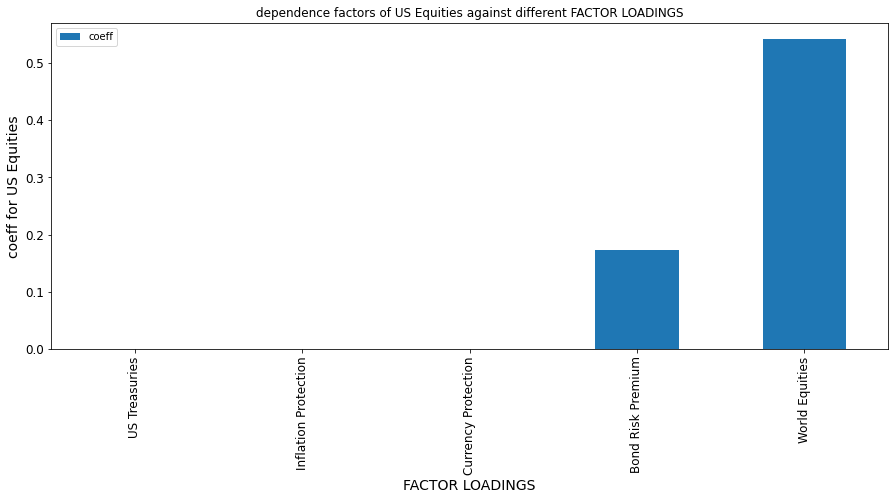

In [34]:
from sklearn.linear_model import Lasso
options = create_options()
options['lambda'] = .1
options['printLoadings'] = True
options['nameOfReg'] = 'LASSO Regression'
lasso_regression(all_data, 'US Equities',factorName, options)

LASSO sets factor loadings to zero. Because of this, it can filter out noise variables. Let's rerun the analysis including the noise variable.

In [35]:
#Calculate a noise variable
std = all_data['World Equities'].std()*(2)
nPeriods = all_data.shape[0]
np.random.seed(1245)
noise = np.random.normal(loc=0, size=(nPeriods))
noise = np.reshape(std*noise + np.array(all_data['World Equities']), (nPeriods,1))
all_data['Noise'] = noise
factorNameWithNoise = factorName + ['Noise']

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
lambda = 0.1
                      Intercept  World Equities  US Treasuries  \
LASSO Reg with noise   0.005388        0.542292            0.0   

                      Bond Risk Premium  Inflation Protection  \
LASSO Reg with noise           0.173226                   0.0   

                      Currency Protection  Noise  
LASSO Reg with noise                  0.0   -0.0  


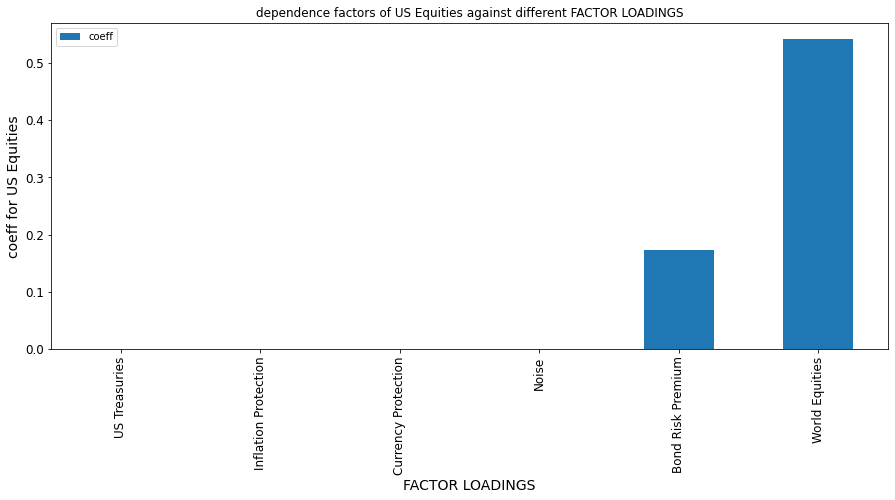

In [38]:
options = create_options()
options['lambda'] = .1
options['printLoadings'] = True
options['nameOfReg'] = 'LASSO Reg with noise'
lasso_regression(all_data, 'US Equities', factorNameWithNoise, options)

Depending on the noise, and the value of lambda, LASSO may shrink noise coeficient, or set it equal to zero. Let's try with a larger lambda.

we will see that for large lambda values, many coeficients are set to zero, including the noise term.

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
lambda = 0.2
                      Intercept  World Equities  US Treasuries  \
LASSO Reg with noise   0.005636        0.513609            0.0   

                      Bond Risk Premium  Inflation Protection  \
LASSO Reg with noise           0.104695                   0.0   

                      Currency Protection  Noise  
LASSO Reg with noise                  0.0    0.0  


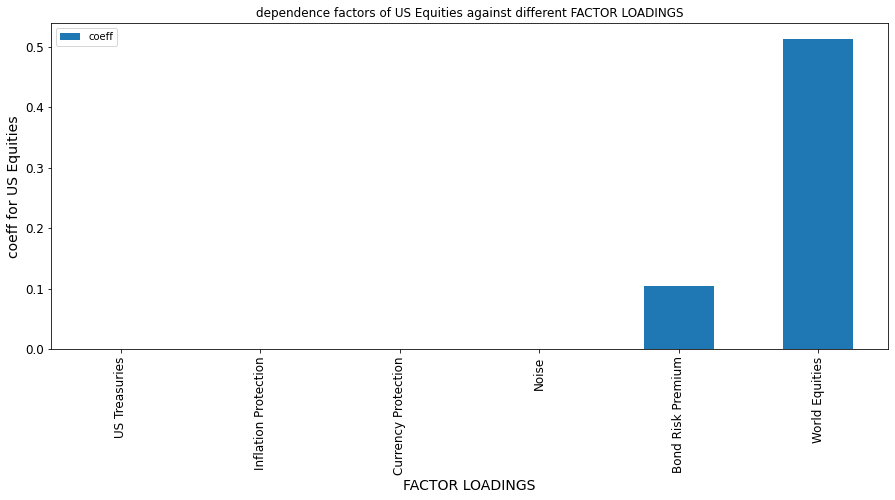

In [39]:
options['lambda'] = .2
lasso_regression(all_data, 'US Equities', factorNameWithNoise, options)

# Cross Validation 

we will break the training set into  𝑘  folds, and define a list of  𝜆  values. For each fold, and for each  𝜆 ,we wil train the model  𝑘−1  other folds, and calculate the error on the test fold. 

At the end of this, we will have  𝑘  out of sample errors for each value of lambda. Then pick the  𝜆  which satisfies the average error across our out of sample tests.

Hence,by using cross validation we will be able to  pick the optimal lambda value for lasso.

In [50]:
def cross_validated_lasso_regression(data, dependentVar, factorNames, options):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['timeperiod'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['timeperiod'])

    #Do CV Lasso
    alphaMax = options['maxLambda'] / (2*newData.shape[0])
    alphas = np.linspace(1e-6, alphaMax, options['nLambdas'])
    if(options['randomState'] == 'none'):
        lassoTest = Lasso(fit_intercept=True)
    else:
        lassoTest = Lasso(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas}]

    clf = GridSearchCV(lassoTest, tuned_parameters, cv=options['nFolds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    lassoBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']

    if (options['printLoadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('best lambda = ' + str(alphaBest*2*newData.shape[0]))
        #Now print the factor loadings
        out=display_factor_loadings(lassoBest.intercept_, lassoBest.coef_, factorNames, options)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(out)
        df_m=pd.DataFrame({'features':factorNames,'coeff':lassoBest.coef_})
        df_m=df_m.sort_values(by=['coeff'])
        df_m.plot(x='features',y='coeff',kind='bar',figsize=(15,6))
        plt.title('dependence factors of US Equities against different FACTOR LOADINGS')
        plt.xlabel('FACTOR LOADINGS')
        plt.ylabel('coeff for US Equities')
        plt.show();

    if(options['returnModel']):
        return lassoBest

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
best lambda = 0.015912424242424242
          Intercept  World Equities  US Treasuries  Bond Risk Premium  \
CV Lasso   0.001211         0.53405        0.46859           0.539369   

          Inflation Protection  Currency Protection  
CV Lasso              0.001968             0.469029  


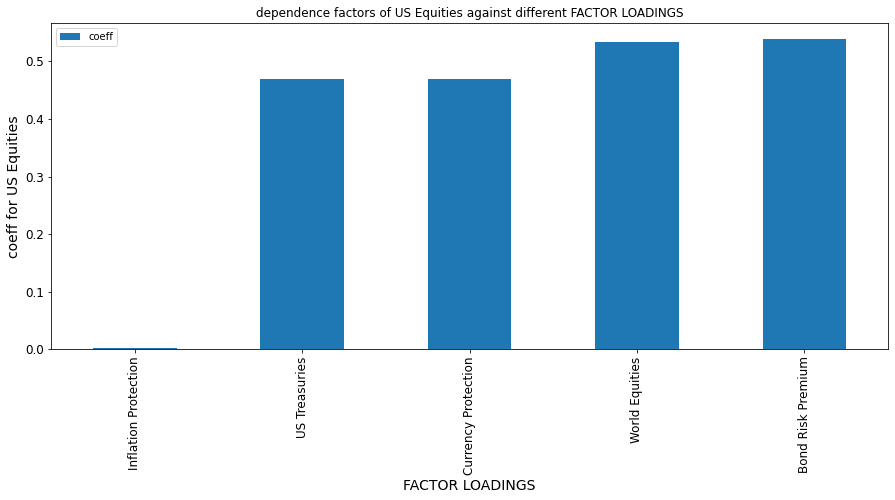

In [51]:
from sklearn.model_selection import GridSearchCV
options['nameOfReg'] = 'CV Lasso'
options['maxLambda'] = .25
options['nLambdas'] = 100
options['randomState'] = 7777
options['nFolds'] = 10
cross_validated_lasso_regression(all_data, 'US Equities',factorName, options)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
best lambda = 0.015912424242424242
          Intercept  World Equities  US Treasuries  Bond Risk Premium  \
CV Lasso     0.0011         0.55413       0.471283           0.538814   

          Inflation Protection  Currency Protection    Noise  
CV Lasso                   0.0             0.469665 -0.01651  


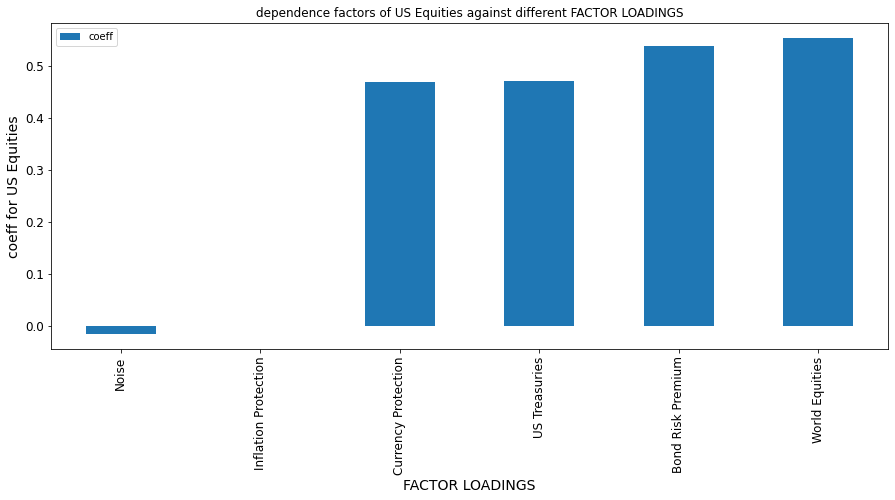

In [52]:
cross_validated_lasso_regression(all_data, 'US Equities', factorNameWithNoise, options)

# Elastic Net

we hae used LASSO regression earlier.  

Another form of regression namely Ridge regression  shrinks coeficients to provide a more robust solution. Combined, it's called an Elastic Net, and it can provide the benefits of both LASSO regression and Ridge regression.

Here we will use  n which is the number of data points, and m is the number of factors.

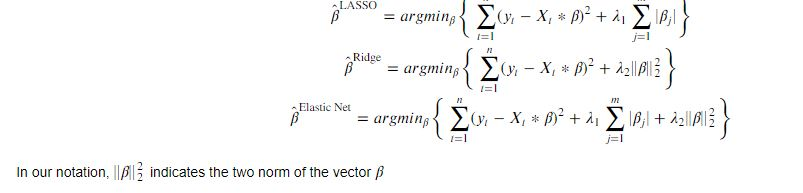

In [53]:
def cross_validated_elastic_net_regression(data, dependentVar, factorNames, options):
    '''cross_validated_elastic_net_regression takes in a dataset and returns the factor loadings using elastic net, also chooses alpha and l1 ratio via cross validation
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            maxL1Ratio: float
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  So I change Lambda -> Alpha in the following code
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Test timeperiod
    if(options['timeperiod'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['timeperiod'])

    #Do CV Lasso
    alphaMax = options['maxLambda']/(2*newData.shape[0])
    alphas = np.linspace(1e-6, alphaMax, options['nLambdas'])
    l1RatioMax = options['maxL1Ratio']
    l1Ratios = np.linspace(1e-6, l1RatioMax, options['nL1Ratios'])

    if(options['randomState'] == 'none'):
        elasticNetTest = ElasticNet(fit_intercept=True)
    else:
        elasticNetTest = ElasticNet(random_state = options['randomState'], fit_intercept=True)

    tuned_parameters = [{'alpha': alphas, 'l1_ratio': l1Ratios}]

    clf = GridSearchCV(elasticNetTest, tuned_parameters, cv=options['nFolds'], refit=True)
    clf.fit(newData[factorNames],newData[dependentVar])
    elasticNetBest = clf.best_estimator_
    alphaBest = clf.best_params_['alpha']
    l1RatioBest = clf.best_params_['l1_ratio']

    if (options['printLoadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)
        print('best lambda1 = ' + str(alphaBest*2*newData.shape[0]*l1RatioBest))
        print('best lambda2 = ' + str(newData.shape[0]*alphaBest*(1-l1RatioBest)))
        #Now print the factor loadings
        out=display_factor_loadings(elasticNetBest.intercept_, elasticNetBest.coef_, factorNames, options)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(out)
        df_m=pd.DataFrame({'features':factorNames,'coeff':elasticNetBest.coef_})
        df_m=df_m.sort_values(by=['coeff'])
        df_m.plot(x='features',y='coeff',kind='bar',figsize=(15,6))
        plt.title('dependence factors of US Equities against different FACTOR LOADINGS')
        plt.xlabel('FACTOR LOADINGS')
        plt.ylabel('coeff for US Equities')
        plt.show();

    if(options['returnModel']):
        return elasticNetBest

In [54]:
options['maxLambda'] = .25
options['maxL1Ratio'] = .99
options['nLambdas'] = 100
options['nL1Ratios'] = 100
options['randomState'] = 7777
options['nFolds'] = 10
options['nameOfReg'] = 'CV Elastic Net'

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
best lambda1 = 0.001157019215573921
best lambda2 = 0.018704520695243337
                Intercept  World Equities  US Treasuries  Bond Risk Premium  \
CV Elastic Net    0.00131        0.534691       0.452806           0.517345   

                Inflation Protection  Currency Protection  
CV Elastic Net              0.062094             0.451863  


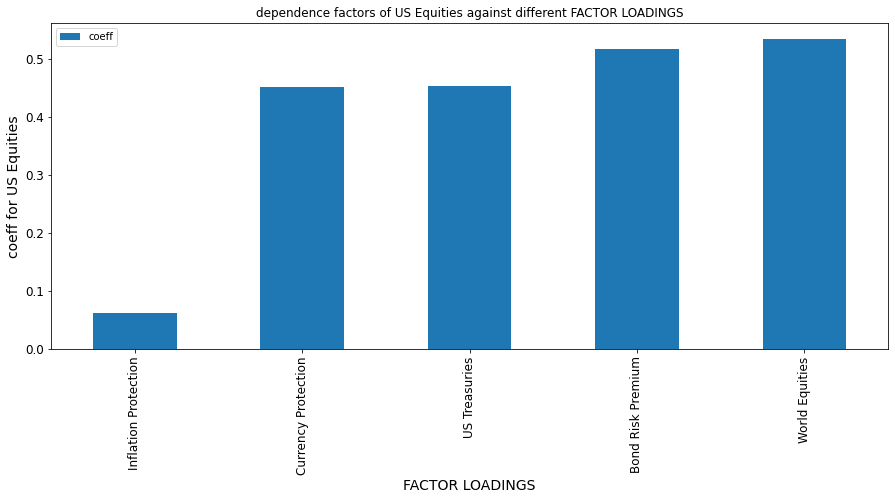

In [55]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
cross_validated_elastic_net_regression(all_data, 'US Equities',factorName, options)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
best lambda1 = 0.0024650264720324456
best lambda2 = 0.019309052420549432
                           Intercept  World Equities  US Treasuries  \
CV Elastic Net with Noise   0.001316        0.553595       0.444955   

                           Bond Risk Premium  Inflation Protection  \
CV Elastic Net with Noise           0.510588              0.050376   

                           Currency Protection     Noise  
CV Elastic Net with Noise             0.438206 -0.016295  


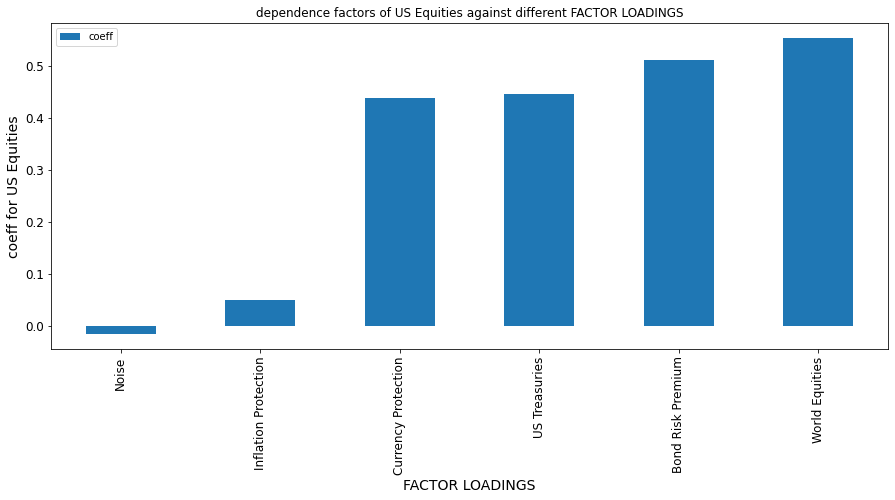

In [56]:
options['nameOfReg'] = 'CV Elastic Net with Noise'
cross_validated_elastic_net_regression(all_data, 'US Equities',factorNameWithNoise, options)

# ELASTIC NET GIVES BETTER RESULTS WITH HIGHLY CORRELATED VARIALES:

Here Elastic net did not do much better than LASSO because we don't have many highly correlated variables. If we had many highly correlated factors, we would expect the Elastic Net to outperform LASSO. 

# Best Subset Regression :

 It attempts to find the linear model subject to the constraint that only "x" factor loadings can be nonzero. In this case, "x" is an integer the user defines.

Here, Let  𝐳  be a vector of binary variables, let  𝑀  be a very large number For simplicity, let  total_vars  be the number of variables considered and  max_vars  be the number max number of variables allowed in the subset.

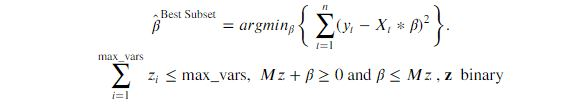

In [57]:
def best_subset_regression(data, dependentVar, factorNames, options):
    '''best_subset_regression takes in a dataset and returns the factor loadings using best subset regression
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            maxVars: int, maximum number of factors that can have a non zero loading in the resulting regression
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''
    #Check dictionary for maxVars option
    if('maxVars' not in options.keys()):
        print ('maxVars not specified in options')
        return

    if(options['timeperiod'] == 'all'):
        newData = data.copy()
    else:
        newData = data.copy()
        newData = newData.query(options['timeperiod'])

    #perform linear regression
    alpha, beta = best_subset(data[factorNames].values, data[dependentVar].values, options['maxVars'])
    
    if (options['printLoadings'] == True):
        #Now print the results
        print_timeperiod(newData, dependentVar, options)

        #Now print the factor loadings
        out=display_factor_loadings(alpha, beta, factorNames, options)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.max_rows', None)
        print(out)

    if(options['returnModel']):
        out = LinearRegression()
        out.intercept_ = alpha[0]
        out.coef_ = beta
        return out

In [58]:
def best_subset(x,y,l_0):
    # Mixed Integer Programming in feature selection
    M = 1000
    n_factor = x.shape[1]
    z = cp.Variable(n_factor, boolean=True)
    beta = cp.Variable(n_factor)
    alpha = cp.Variable(1)

    def MIP_obj(x,y,b,a):
        return cp.norm(y-cp.matmul(x,b)-a,2)

    best_subset_prob = cp.Problem(cp.Minimize(MIP_obj(x, y, beta, alpha)), 
                             [cp.sum(z)<=l_0, beta+M*z>=0, M*z>=beta])
    best_subset_prob.solve()
    return alpha.value, beta.value

In [59]:
import cvxpy as cp
options['maxVars'] = 2
options['nameOfReg'] = 'Best Subset with maxVars = 2'
best_subset_regression(all_data, 'US Equities',factorName, options)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 2   0.005139        0.570965  -1.134489e-09   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 2           0.241762         -3.286596e-11   

                              Currency Protection  
Best Subset with maxVars = 2        -2.202826e-10  


In [60]:
options['maxVars'] = 3
options['nameOfReg'] = 'Best Subset with maxVars = 3'
best_subset_regression(all_data, 'US Equities',factorName, options)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 3   0.001766        0.480828       0.559776   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 3           0.631868          9.721428e-12   

                              Currency Protection  
Best Subset with maxVars = 3         1.364468e-10  


In [61]:
options['maxVars'] = 3
options['nameOfReg'] = 'Best Subset with maxVars = 3'
best_subset_regression(all_data, 'US Equities', factorNameWithNoise, options)

Dependent Variable is US Equities
Time period is between January 1985 to September 2018 inclusive   
                              Intercept  World Equities  US Treasuries  \
Best Subset with maxVars = 3   0.001766        0.480828       0.559774   

                              Bond Risk Premium  Inflation Protection  \
Best Subset with maxVars = 3           0.631867          3.301118e-11   

                              Currency Protection         Noise  
Best Subset with maxVars = 3         7.989926e-12 -2.627088e-09  


In [ ]:
!jupyter nbconvert Factomodels_Alternative_ML_Methods.ipynb

[NbConvertApp] Converting notebook Factomodels_Alternative_ML_Methods.ipynb to html
[NbConvertApp] Writing 424546 bytes to Factomodels_Alternative_ML_Methods.html
